#### Starbucks locations in washington DC

Suppose we are a supplier and we want to supply coffee beans to starbucks locations inside DC. we will use route optimization techniques to find the best possible route to visit all the store locations exactly once and go back to the original home node. this is an extension on the TSP problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

#for network and graph analysis
import networkx as nx
import osmnx as ox

#filter warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_stores.csv')

state = 'DC'
city = 'Washington'
country = 'US'

In [3]:
df_local = df[(df['State/Province']==state) &
               (df['City'] == city) & 
               (df['Country']==country) & 
               (df['Brand'] == 'Starbucks')]\
                [['Street Address','Longitude', 'Latitude']].sample(frac=1).reset_index(drop=True)

df_local = df_local.drop_duplicates((['Longitude','Latitude']),keep='first').reset_index().rename(columns={'index':'id','Street Address':'address', 'Latitude':'y', 'Longitude':'x'})
df_local.reset_index(inplace=True)
df_local.drop(columns=['id'],inplace=True)
df_local.head()

,index,address,x,y
0,0,"1825 I Street NW, Capital Gallery",-77.04,38.90
1,1,"1200 New Jersey Ave., SE",-77.00,38.88
2,2,3336 Wisconsin Ave NW,-77.07,38.93
3,3,500 New Jersey Avenue NW,-77.01,38.90
4,4,700 14th Street NW,-77.03,38.90


In [4]:
data = df_local.copy()

In [6]:
data.head(3)

,index,address,x,y
0,0,"1825 I Street NW, Capital Gallery",-77.04,38.90
1,1,"1200 New Jersey Ave., SE",-77.00,38.88
2,2,3336 Wisconsin Ave NW,-77.07,38.93


In [16]:
data['color'] = ''
data.loc[data['index'] == 0, 'color'] = 'red'
data.loc[data['index'] != 0, 'color'] = 'black'

start = data[data['index'] == 0][['y','x']].values[0]

#print(start)
data.head(3)

,index,address,x,y,color
0,0,"1825 I Street NW, Capital Gallery",-77.04,38.90,red
1,1,"1200 New Jersey Ave., SE",-77.00,38.88,black
2,2,3336 Wisconsin Ave NW,-77.07,38.93,black


In [24]:
# create a map of DC - starting from the first starbucks location
map = folium.Map(
    location= start,
    titles = 'carthodbpositron',
    zoom_start=12
)

# create indictators for starbucks stores on the map using a colored circle
data.apply( lambda row:
           folium.CircleMarker(location= [row['y'],row['x']],
                               color = row['color'],
                               fill = True,
                               radius=2.5).add_to(map),axis=1

)

map

#### Creating graphs with nodes and edges

so here  I will use open street maps networkx to create a network (graph) of all the possible routes between starbucks stores

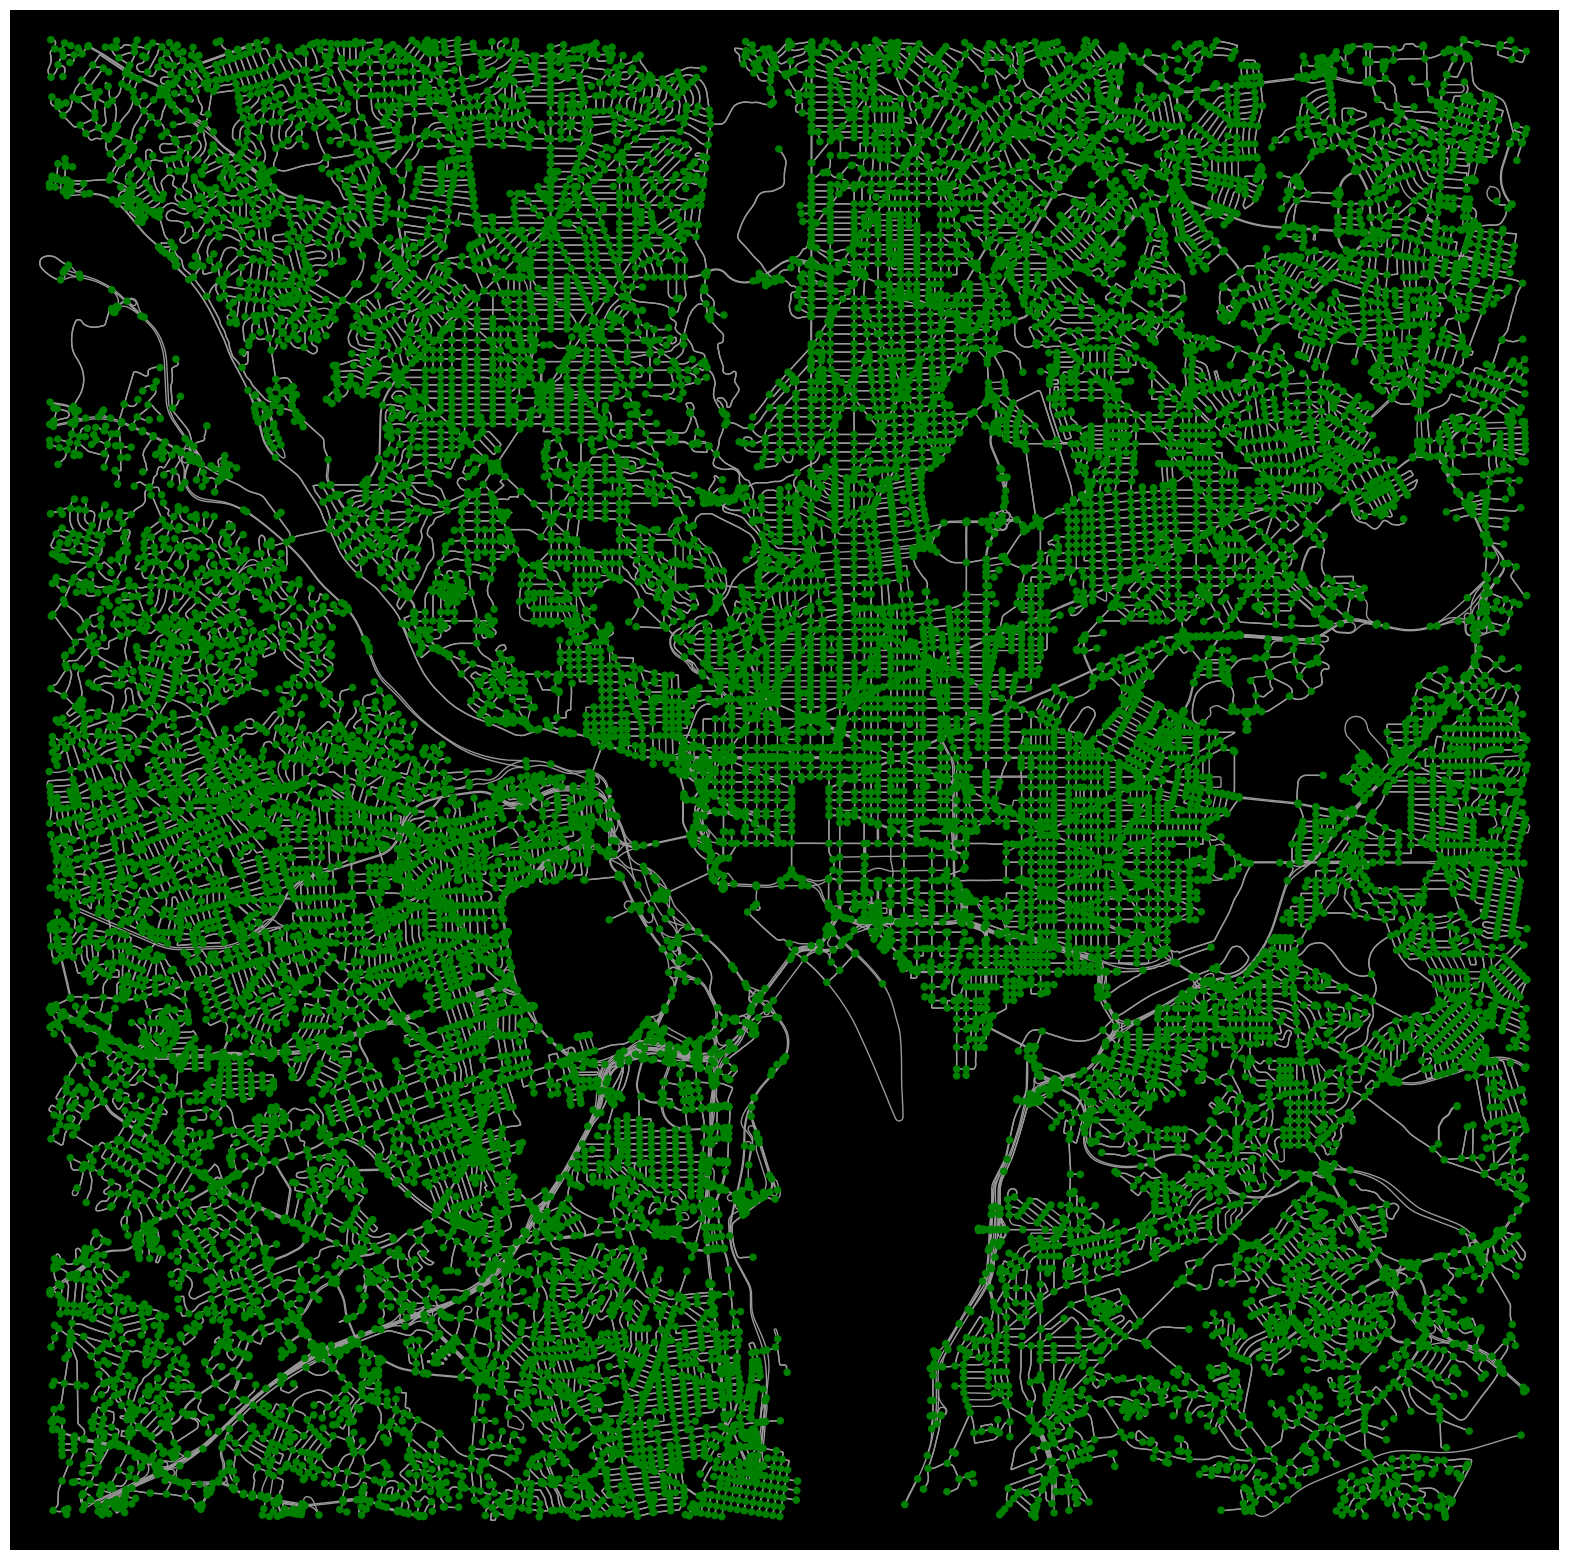

In [28]:
G = ox.graph_from_point(start, dist= 10e3, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.add_edge_bearings(G)

fig,ax = ox.plot_graph(G,bgcolor="black", node_size = 30, node_color = 'green', figsize = (30,20))